# Foundry-Compatible PIC Design Flow

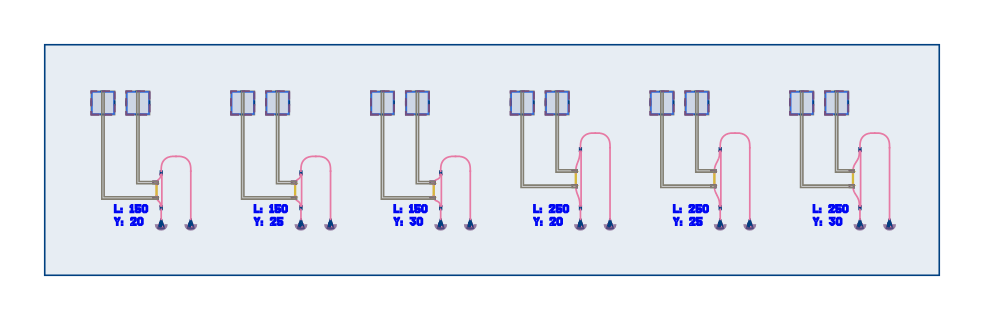

In this demo, we'll learn how to:

- Load PDK components and custom components from GDSII files;
- Run component-level simulations (MODE, FDTD);
- Create a netlist-driven layout of components; and
- Simulate the complete photonics circuit.

We begin by loading PhotonForge, Tidy3D, the [SiEPIC OpenEBL PDK](https://siepic.ca/openebl/), and other common Python modules we will be using.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import siepic_forge as siepic
import tidy3d as td

# Start the live viewer for interactive visualization
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer()

Starting live viewer at http://localhost:5001


We use the default SiEPIC PDK as our default technology and set some configurations.

In [2]:
tech = siepic.ebeam()
pf.config.default_technology = tech

# We lower the default mesh refinement to decrease the sizes of the simulations.
# For more accurate results, higher values should be used.
pf.config.default_mesh_refinement = 12

pf.config.svg_labels = False
td.config.logging_level = "ERROR"

# Set frequency range
wavelengths = np.linspace(1.5, 1.6, 101)

Review the available layers in the PDK:

In [3]:
tech.layers

Name          Layer    Description    Color    Pattern
--------------------------------------------------------------
BlackBox             (998, 0)  SiEPIC       #00408018   solid 
Chip design area     (290, 0)  Misc         #80005718   hollow
Deep Trench          (201, 0)  Misc         #c0c0c018   solid 
DevRec               (68, 0)   SiEPIC       #00408018   hollow
Dicing               (210, 0)  Misc         #a0a0c018   solid 
Errors               (999, 0)  SiEPIC       #00008018     /   
FDTD                 (733, 0)  SiEPIC       #80005718   hollow
FbrTgt               (81, 0)   SiEPIC       #00408018     /   
FloorPlan            (99, 0)   Misc         #8000ff18   hollow
Isolation Trench     (203, 0)  Misc         #c0c0c018   solid 
Keep out             (202, 0)  Misc         #a0a0c018     //  
M1_heater            (11, 0)   Metal        #ebc63418     xx  
M2_router            (12, 0)   Metal        #90857018     xx  
M_Open               (13, 0)   Metal        #3471eb18     xx  
Oxide open (to BOX)   (6, 0)   Waveguides   #ffae0018     \   
PinRec               (1, 10)   SiEPIC       #00408018     /   
PinRecM              (1, 11)   SiEPIC       #00408018     /   
SEM                  (200, 0)  Misc         #ff00ff18     \   
Si                    (1, 0)   Waveguides   #ff80a818     \\  
Si N                 (20, 0)   Doping       #7000ff18     \\  
Si N++               (24, 0)   Doping       #0000ff18     :   
Si slab               (2, 0)   Waveguides   #80a8ff18     /   
SiN                   (4, 0)   Waveguides   #a6cee318     \\  
Si_Litho193nm        (1, 69)   Waveguides   #cc80a818     \   
Text                 (10, 0)                #0000ff18     \   
VC                   (40, 0)   Metal        #3a027f18     xx  
Waveguide            (1, 99)   Waveguides   #ff80a818     \

Inspect available PDK components:

In [4]:
siepic.component_names

{'ANT_MMI_1x2_te1550_3dB_BB',
 'GC_SiN_TE_1310_8degOxide_BB',
 'GC_SiN_TE_1550_8degOxide_BB',
 'GC_TE_1310_8degOxide_BB',
 'GC_TE_1550_8degOxide_BB',
 'GC_TM_1310_8degOxide_BB',
 'GC_TM_1550_8degOxide_BB',
 'crossing_horizontal',
 'crossing_manhattan',
 'ebeam_BondPad',
 'ebeam_DC_2-1_te895',
 'ebeam_DC_te895',
 'ebeam_MMI_2x2_5050_te1310',
 'ebeam_Polarizer_TM_1550_UQAM',
 'ebeam_YBranch_895',
 'ebeam_YBranch_te1310',
 'ebeam_adiabatic_te1550',
 'ebeam_adiabatic_tm1550',
 'ebeam_bdc_te1550',
 'ebeam_crossing4',
 'ebeam_gc_te1550',
 'ebeam_gc_te895',
 'ebeam_gc_tm1550',
 'ebeam_routing_taper_te1550_w=500nm_to_w=3000nm_L=20um',
 'ebeam_routing_taper_te1550_w=500nm_to_w=3000nm_L=40um',
 'ebeam_splitter_swg_assist_te1310',
 'ebeam_splitter_swg_assist_te1550',
 'ebeam_terminator_SiN_1550',
 'ebeam_terminator_SiN_te895',
 'ebeam_terminator_te1310',
 'ebeam_terminator_te1550',
 'ebeam_terminator_tm1550',
 'ebeam_y_1550',
 'ebeam_y_adiabatic',
 'ebeam_y_adiabatic_500pin',
 'taper_SiN_750_3000

## Loading a PDK component

We will use a couple of components readily available in the PDK.

In [5]:
gc = siepic.component("ebeam_gc_te1550")
viewer.display(gc)

We can plot the geometry cross-section with the [tidy3d_plot](../_autosummary/photonforge.tidy3d_plot.rst) function.

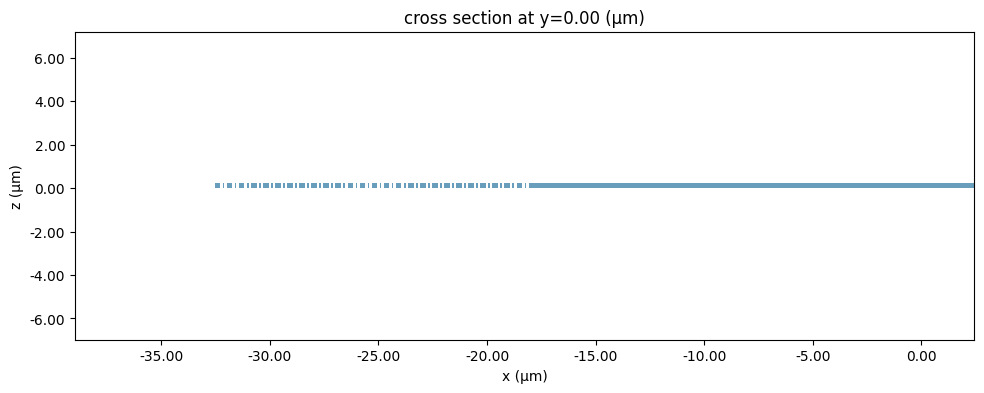

In [6]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = pf.tidy3d_plot(gc, plot_type="structures", y=0, ax=ax)

Most PDK components will have appropriate ports or terminals for connections, and some will include pre-defined models for S parameter computation.

In [7]:
y_splitter = siepic.component("ebeam_y_1550")
viewer.display(y_splitter)

In [8]:
y_splitter.ports

{'P2': Port(center=(7.4, 2.75), input_direction=180, spec=PortSpec(description="Strip TE 1550 nm, w=500 nm", width=2, limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=3.5, path_profiles=[(0.5, 0, (1, 0))]), extended=True, inverted=False),
 'P1': Port(center=(7.4, -2.75), input_direction=180, spec=PortSpec(description="Strip TE 1550 nm, w=500 nm", width=2, limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=3.5, path_profiles=[(0.5, 0, (1, 0))]), extended=True, inverted=False),
 'P0': Port(center=(-7.4, 0), input_direction=0, spec=PortSpec(description="Strip TE 1550 nm, w=500 nm", width=2, limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=3.5, path_profiles=[(0.5, 0, (1, 0))]), extended=True, inverted=False)}

In [9]:
y_splitter.models

{'Tidy3D': Tidy3DModel(run_time=None, medium=None, symmetry=(0, 0, 0), boundary_spec=None, monitors=(), structures=(), grid_spec=None, shutoff=None, subpixel=None, courant=None, port_symmetries=[('P1', 'P2', {'P0': 'P0', 'P2': 'P1'})], bounds=((None, None, None), (None, None, None)), verbose=True)}

## Running FDTD simulations

The Y splitter already has a [Tidy3D model](../guides/Tidy3D_Model.ipynb) and waveguide ports, so a simple call to the [s_matrix](../_autosummary/photonforge.Component.rst#photonforge.Component.s_matrix) method is all that is needed to compute its S parameters.

In [10]:
s_matrix_tidy3d = y_splitter.s_matrix(frequencies=td.C_0 / wavelengths)

Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-UBQTVGGC6XVM7NFRW2XG6QO4R2DPOYFYI67ILLVRYIQFJWZNALQQ.json.


Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-4BFSWMT53SONUH3PMBMPT25EYG53N66TKL34L44A6U4XAFR4HDAQ.json.
Progress: 100% 


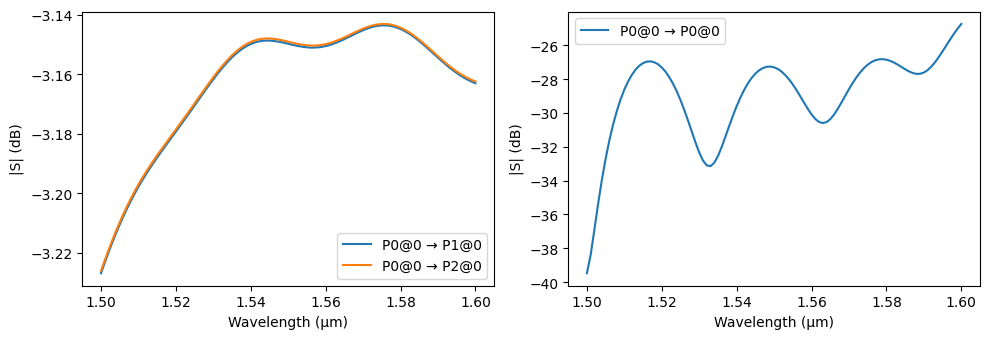

In [11]:
# Plot the S-parameters
_ = pf.plot_s_matrix(s_matrix_tidy3d, input_ports=["P0"], y="dB")

## Running MODE simulations

It is really easy to inspect port modes as well.
The [port_modes](../_autosummary/photonforge.port_modes.rst) function will compute the modes and return a Tidy3D `ModeSolver` object with the mode data.

In [12]:
mode_solver = pf.port_modes(
    y_splitter.ports["P0"],
    frequencies=[pf.C_0 / 1.5, pf.C_0 / 1.55, pf.C_0 / 1.6],
    mesh_refinement=40,
    group_index=True,
)

Loading cached simulation from .tidy3d/pf_cache/ILP/ms_info-6ROYYJ6Q3MRHGGYTZ7SDXDRVOMAQI3DDDQR2D73MMIZXFGDKCE2Q.json.


In [13]:
mode_solver.data.to_dataframe()

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.998616e+14 0                 1.50  2.498958    0.0          0.985869   
1.934145e+14 0                 1.55  2.442842    0.0          0.983432   
1.873703e+14 0                 1.60  2.386511    0.0          0.980722   

                         wg TE fraction  wg TM fraction  mode area  \
f            mode_index                                              
1.998616e+14 0                 0.776566        0.820781    0.17719   
1.934145e+14 0                 0.763903        0.817670    0.19134   
1.873703e+14 0                 0.751868        0.814869    0.20698   

                         group index  dispersion (ps/(nm km))  
f            mode_index                                        
1.998616e+14 0              4.178617               895.802013  
1.934145e+14 0              4.186826             -2390.556693  
1.873703e+14 0              4.194630               890.712229

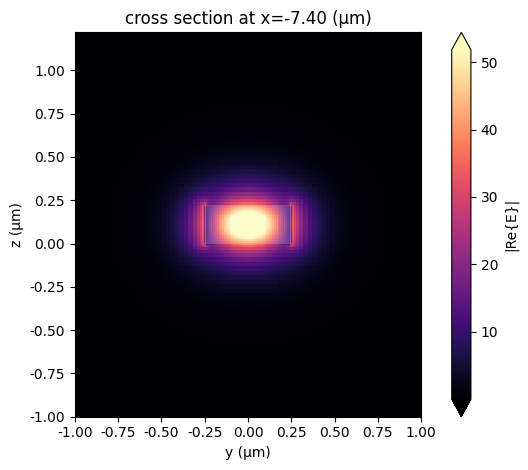

In [14]:
_ = mode_solver.plot_field("E", mode_index=0, f=pf.C_0 / 1.55)

## Loading a GDSII file

Custom components can be loaded from GDSII files.
We will load a phase shifter designed previously and available in the file `thermo-optic_phase_shifter.gds`.

To make sure the file is always available, the next cell creates the file automatically from its binary contents, so you do not need to download a separate file to run this notebook.

In [15]:
import bz2
import pathlib

_ = pathlib.Path("thermo-optic_phase_shifter.gds").write_bytes(
    bz2.decompress(
        b"BZh91AY&SY\x91\x99q2\x00\x00/\xff\xff\xff\xff\xeeD$\x06\x80\xf16H@P\xaa\x06\xc4@\x00`\x00H@\x80\x00@\t\x02\x80\x04\x00D\x05\x10\xb0\x00\xf6"
        b"5\r\x12\x99\x06\x9a\x00\xd0\xd0\x00\x00\x07\xa8\x00\xd3\xc4\xd2\x06\x88\xa6\x9aa=@\xd3L\x80\x00\xd3CLF\x9a\x00\x00$RiM\xa9\x93FG\xea\x9a"
        b"\x06\x98\x04\x00\x00\x1a`hD\xbd\xe2\t\x93A`K\x99\x820\x10a\xab \x97\x0c\xa9D(\x94\x08\x91$\x11s\x1a\xd5\x14s\x19\xef\x8e\xc7\xd9UYd\x98\x1e"
        b"\xefp7`\x82\\\x87(\xe64\x83\xbc\x13UX\x81\x90\x8a\xa6A\xe9\xcd\x14t\x83\x04be\xecm\x17\xc52\x9e\xc5\xfa\xf8L,\xc6\xcc\x14\x01Q\xa3z\xdd\x04"
        b'\xca\xd3B\x87<*H\x89\x04j"\x86\x10\x82JpR\xeb\xae\xc2p\x9d\x004\x18\x97!\x04\x10\x0b\x89\xa5#\x80@\x9e\xc9{\x01\x04\xb4\xbc\x98\x81\x8bT^'
        b"\xd5\xbd\xc53W\x07\x18\x8c\xa6\x8d\x01N\x9d\x94\xd1l5\xedP\x15\xc0\xd8\x1bb#\xcd\xa2q\x82YN\x1bDl@\x8c :\xb5\x9c\xcf\x8f\x19\x8f\xe2\xeeH"
        b"\xa7\n\x12\x123.&@"
    )
)

With the file created, we can load in with the [load_layout](../_autosummary/photonforge.load_layout.rst) function.
The loaded layout is a dictionary with all GDSII cells as components:

In [16]:
components = pf.load_layout("thermo-optic_phase_shifter.gds")
components.keys()

dict_keys(['top_cell'])

In [17]:
phase_shifter = components["top_cell"]
viewer.display(phase_shifter)

The GDSII format has no standard support for terminals, ports or models, so we have to add them after loading the geometry data:

In [18]:
phase_shifter.terminals

{}

In [19]:
phase_shifter.ports

{}

In [20]:
phase_shifter.models

{}

In most cases, we can automatically detect and add ports.
If we know which [port specification](../guides/Ports.ipynb) the geometry uses, we can use it to reduce the number of false positive results.
In this case, we look for ports matching the "TE_1550_500" specification from the default technology.

In [21]:
ports = phase_shifter.detect_ports(["TE_1550_500"])
ports

[Port(center=(0, 0), input_direction=0, spec=PortSpec(description="Strip TE 1550 nm, w=500 nm", width=2, limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=3.5, path_profiles=[(0.5, 0, (1, 0))]), extended=True, inverted=False),
 Port(center=(50, 0), input_direction=180, spec=PortSpec(description="Strip TE 1550 nm, w=500 nm", width=2, limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=3.5, path_profiles=[(0.5, 0, (1, 0))]), extended=True, inverted=False)]

Both results are correct, so we can go ahead and add them:

In [22]:
phase_shifter.add_port(ports)

viewer.display(phase_shifter)

Being a straight waveguide, a semi-analytical [waveguide model](../_autosummary/photonforge.WaveguideModel.rst) makes sense for this component.

In [23]:
phase_shifter.add_model(pf.WaveguideModel(), "Waveguide")

'Waveguide'

Terminals for electrical connection are represented by the 2 rectangles in layer (12, 0), "M2_router".
We can easily find them and add the appropriate [terminals](../guides/Electrical_Ports.ipynb#Terminals) for routing later.

In [24]:
for structure in phase_shifter.structures[12, 0]:
    phase_shifter.add_terminal(pf.Terminal("M2_router", structure))

viewer.display(phase_shifter)

We can store the phase-shifter with the terminal, port and model information if we use a PhotonForge PHF file with the [write_phf](../_autosummary/photonforge.write_phf.rst) function:

In [25]:
pf.write_phf("thermo-optic_phase_shifter.phf", phase_shifter)

## Netlist-driven layout

We can now combine these PDK and custom components to form a cirucit for both layout and simulations.
This can be done in an imperative way, by creating and connecting component references using the PhotonForge API, or in a declarative way, using a netlist to fully specify the circuit in a single object.
The former approach can be seen in the [Quantum Chip](Quantum_Chip.ipynb) and [LIDAR](Lidar.ipynb) examples.
Here we show the latter.

We set the defaults that will be used for routing and get the bounds information from the components we will use:

In [26]:
pf.config.default_kwargs = {
    "radius": 10,
    "euler_fraction": 0.5,
}

In [27]:
y_splitter.bounds()

(array([-7.5 , -3.75]), array([7.45, 3.75]))

In [28]:
phase_shifter.bounds()

(array([-13.,  -5.]), array([63., 15.]))

In [29]:
def create_mzi(length=150, ps_y=25):
    netlist = {
        "name": "MZI",
        # Individual component instances
        "instances": {
            "yin": y_splitter,
            "yout": {"component": y_splitter, "origin": (length, 0), "rotation": 180},
            "ps": {"component": phase_shifter, "origin": (length / 2 - 25, ps_y)},
        },
        # Auto-routing
        "routes": [
            (("yin", "P2"), ("ps", "P0"), pf.parametric.route_s_bend),
            (("ps", "P1"), ("yout", "P1"), pf.parametric.route_s_bend),
            (("yin", "P1"), ("yout", "P2")),
        ],
        # External ports and terminals
        "ports": [("yin", "P0"), ("yout", "P0")],
        "terminals": [("ps", "T0"), ("ps", "T1")],
        # Model for the full circuit
        "models": [pf.CircuitModel()],
    }

    component = pf.component_from_netlist(netlist)
    return component


mzi = create_mzi()
viewer.display(mzi)

## Circuit simulations

With the [circuit model](../guides/Circuit_Model.ipynb) we added to the MZI, we can run circuit simulations by simply calling the `s_matrix` function again.
PhotonForge will automatically run appropriate simulations for the sub-components to calculate the scattering matrix for the whole circuit.

In [30]:
s_matrix_mzi = mzi.s_matrix(pf.C_0 / wavelengths)

Loading cached simulation from .tidy3d/pf_cache/SUK/ms_info-UO4FYHGS5WR3TBEN4XL5ZGMAR54X4H7MMA7YUKZIVFTDLTEVVARA.json.
Loading cached simulation from .tidy3d/pf_cache/LKZ/ms_info-M4UI53R32ROULQ3U2W5LGLKP63MYXLEYQA6XQUWPE2YE2IEET3GQ.json.


Loading cached simulation from .tidy3d/pf_cache/L7Y/ms_info-FHD74EGOKHPRKXR5CPMBVWCZFNORWY4PFOCSHDHAS2SSG3YFYHAA.json.


Progress: 100% 


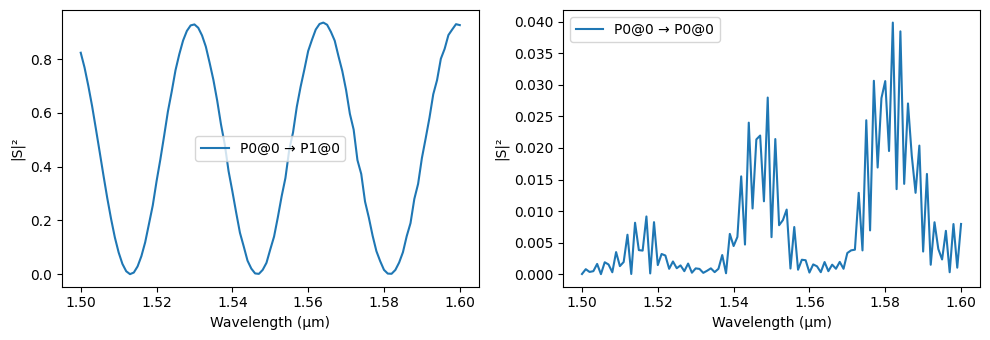

In [31]:
_ = pf.plot_s_matrix(s_matrix_mzi, input_ports=["P0"])

## Adding GCs for layout

Just as before, we use a netlist to describe the circuit with the grating couplers from the PDK.
This function will use the MZI as argument so that we can vary its parameters later when creating the full chip.

In [32]:
def mzi_with_gratings(mzi, fiber_spacing=127, spacing_y=50):
    netlist = {
        "name": "MZI_with_GC",
        "instances": {
            "mzi": {"component": mzi, "origin": (0, spacing_y), "rotation": 90},
            "gc1": {"component": gc, "origin": (0, 0), "rotation": 90},
            "gc2": {"component": gc, "origin": (fiber_spacing, 0), "rotation": 90},
        },
        "routes": [
            (("gc1", "P0"), ("mzi", "P0")),
            (("mzi", "P1"), ("gc2", "P0"), {"radius": fiber_spacing / 2.0}),
        ],
        "ports": [("gc1", "P1"), ("gc2", "P1")],
        "terminals": [("mzi", "T0"), ("mzi", "T1")],
        "models": [pf.CircuitModel()],
    }

    component = pf.component_from_netlist(netlist)
    return component


mzi_gratings = mzi_with_gratings(mzi)

viewer.display(mzi_gratings)

Instead of simulating the grating coupler in Tidy3D, we will show how to use pre-computed or measured data to avoid the large simulations.

The Touchstone file `ebeam_gc_te1550.sp2` contains example data we can load and assign to the grating coupler with a [data model](../guides/Data_Model.ipynb), which could have come from previous measurements, for example.

As with the GDSII file we used previously, we will re-create the Touchstone file from its contents so you don't have to download it separately.

In [33]:
_ = pathlib.Path("ebeam_gc_te1550.s2p").write_text(
    """[Version] 2.0
# Hz S RI
[Number of Ports] 2
[Two-Port Data Order] 12_21
[Number of Frequencies] 31
[Network Data]
1.897421e+14 -0.0352072 0.0326903 -0.226435 -0.447915 0.210738 0.421143 0.00676895 0.0264931
1.899825e+14 -0.0396145 0.00837585 -0.0362153 -0.512323 0.0336372 0.484589 0.00360995 0.0245064
1.902236e+14 -0.0354181 -0.010244 0.169495 -0.496585 -0.161001 0.47345 0.00310874 0.0214094
1.904653e+14 -0.026563 -0.0276462 0.357034 -0.398698 -0.341562 0.383859 0.00534486 0.0196147
1.907077e+14 -0.00635631 -0.0433821 0.493656 -0.230711 -0.47628 0.225361 0.00848205 0.0208979
1.909506e+14 0.0271043 -0.0439097 0.553475 -0.0179504 -0.538816 0.0205268 0.00983997 0.0250636
1.911942e+14 0.0573636 -0.016617 0.523126 0.20503 -0.513759 -0.198027 0.00772578 0.0298957
1.914384e+14 0.0591343 0.0296758 0.404572 0.400752 -0.400509 -0.392852 0.00269386 0.0325817
1.916832e+14 0.0241182 0.0647929 0.214641 0.535193 -0.214451 -0.52857 -0.00274075 0.0316472
1.919286e+14 -0.0260546 0.0625573 -0.0171573 0.582968 0.0150289 -0.578581 -0.0057533 0.0280115
1.921747e+14 -0.0569269 0.0256378 -0.252092 0.532182 0.249155 -0.53042 -0.00514607 0.0244794
1.924213e+14 -0.0517625 -0.0175119 -0.448512 0.38844 0.44637 -0.388954 -0.00231797 0.0238635
1.926687e+14 -0.0230183 -0.04036 -0.570368 0.175072 0.570088 -0.17651 -0.000417023 0.0269198
1.929166e+14 0.00586192 -0.0394758 -0.594637 -0.0712344 0.596004 0.0705136 -0.00209928 0.031656
1.931652e+14 0.0243362 -0.0276428 -0.515563 -0.307241 0.517319 0.308136 -0.00752106 0.034704
1.934145e+14 0.0364941 -0.0125098 -0.345937 -0.490763 0.34663 0.492995 -0.0141874 0.0337846
1.936644e+14 0.0435652 0.00978416 -0.115382 -0.588478 0.114132 0.59075 -0.0187811 0.0293522
1.939149e+14 0.0348038 0.0393164 0.135057 -0.582551 -0.137855 0.583101 -0.0195603 0.0241891
1.941661e+14 0.0019319 0.0592741 0.360515 -0.473915 -0.363013 0.471707 -0.0175394 0.0213398
1.944179e+14 -0.041254 0.0478519 0.520442 -0.282017 -0.520386 0.27783 -0.01565 0.0219132
1.946704e+14 -0.0635397 0.00473916 0.585755 -0.0419279 -0.582075 0.0380054 -0.0165477 0.0243395
1.949236e+14 -0.0456419 -0.0414984 0.545159 0.201759 -0.538441 -0.203066 -0.0206354 0.0255948
1.951774e+14 -0.000953603 -0.0582347 0.407918 0.404146 -0.399799 -0.401147 -0.0258056 0.0235307
1.954319e+14 0.0376615 -0.0388482 0.201359 0.529297 -0.194252 -0.521024 -0.0291419 0.0184768
1.956870e+14 0.0494522 -0.00407037 -0.0353287 0.556626 0.0382115 -0.54334 -0.0291566 0.0128121
1.959428e+14 0.0390625 0.0235674 -0.25862 0.483795 0.254042 -0.467837 -0.0267002 0.00903373
1.961993e+14 0.020525 0.0388267 -0.428387 0.326759 0.414603 -0.312517 -0.0240809 0.00801482
1.964564e+14 -0.00202446 0.0458016 -0.515291 0.116663 0.493245 -0.10946 -0.0232984 0.00859377
1.967142e+14 -0.0303964 0.0403233 -0.506173 -0.106335 0.479893 0.101871 -0.0246625 0.00861082
1.969727e+14 -0.0543518 0.0125664 -0.406116 -0.300777 0.382185 0.282568 -0.0267262 0.0065854
1.972319e+14 -0.0515758 -0.031471 -0.237294 -0.431789 0.223014 0.401693 -0.0275304 0.00276416
[End]"""
)

With the file created, we can load it as an [S matrix](../_autosummary/photonforge.SMatrix.rst) object and use it to create the data model.

In [34]:
s_matrix_data = pf.SMatrix.load_snp("ebeam_gc_te1550.s2p")
data_model = pf.DataModel(s_matrix_data, interpolation_method="akima")

_ = gc.add_model(data_model, "Data")

Progress: 100% 


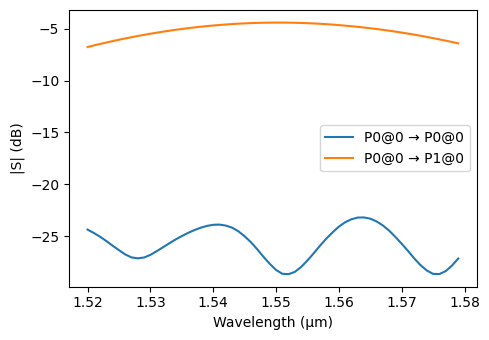

In [35]:
_ = pf.plot_s_matrix(gc.s_matrix(pf.C_0 / wavelengths), y="dB", input_ports=["P0"])

Loading cached simulation from .tidy3d/pf_cache/T7R/ms_info-N6ETNHAW4XHWOCP6GBTAFIPCKWJ5QFTAVRPEOLXPKFUHYDM6UMMQ.json.


Loading cached simulation from .tidy3d/pf_cache/356/ms_info-GTGYBGKWDR72ZZHGMGIHRB4WRRVGDE4QD334N2C53HWVWQGKMXLQ.json.


Progress: 100% 


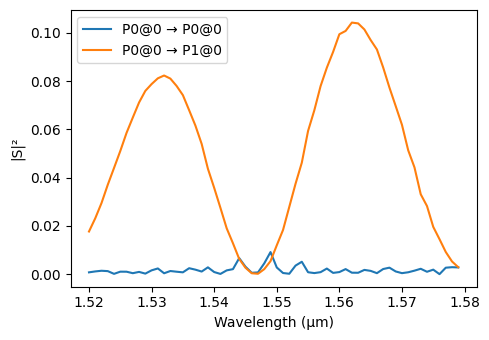

In [36]:
s_matrix_mzi_gratings = mzi_gratings.s_matrix(pf.C_0 / wavelengths)
_ = pf.plot_s_matrix(s_matrix_mzi_gratings, input_ports=["P0"])

## Electrical connections

For the electrical connections we add bond pads to the final layout.

In [37]:
bp = siepic.component("ebeam_BondPad")
viewer.display(bp)

In [38]:
def mzi_with_bond_pads(mzi, bp_x=-250, bp_y=500, bp_spacing=150):
    netlist = {
        "name": "Circuit",
        "instances": {
            "mzi": mzi_with_gratings(mzi),
            "bp1": {"component": bp, "origin": (bp_x, bp_y)},
            "bp2": {"component": bp, "origin": (bp_x + bp_spacing, bp_y)},
        },
        "terminal routes": [
            (("mzi", "T0"), ("bp1", "T0"), {"width": 30, "overlap_fraction": 0.5}),
            (("mzi", "T1"), ("bp2", "T0"), {"width": 30, "overlap_fraction": 0.5}),
        ],
        "ports": [("mzi", "P0"), ("mzi", "P1")],
        "terminals": [("bp1", "T0"), ("bp2", "T0")],
        "models": [pf.CircuitModel()],
    }

    component = pf.component_from_netlist(netlist)
    return component


mzi_bp = mzi_with_bond_pads(mzi)
viewer.display(mzi_bp)

## Final chip layout

We can now easily repeat this design (or variations of it) to build the final layout.

We will vary the MZI parameters to create a few variations:

In [39]:
variations = []

for length in [150, 250]:
    for ps_y in [20, 25, 30]:
        # Create the variation
        base_mzi = create_mzi(length=length, ps_y=ps_y)
        variation = mzi_with_bond_pads(base_mzi)

        # Add a label to identify the device (this could be done in the create_mzi
        # or any other component creation function directly too)
        variation_id = f"L: {length}\nY: {ps_y}"
        variation.add("Text", *pf.text(variation_id, size=50, origin=(-200, 20)))
        variations.append(variation)

viewer.display(variations[0])

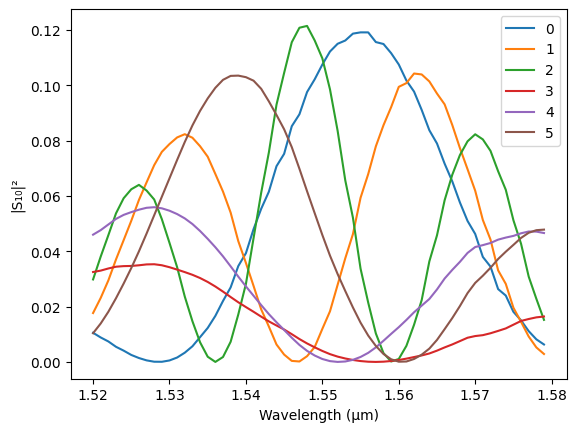

In [40]:
_, ax = plt.subplots(1, 1)
for i, variation in enumerate(variations):
    s = variation.s_matrix(pf.C_0 / wavelengths, show_progress=False)
    ax.plot(s.wavelengths, np.abs(s["P0@0", "P1@0"]) ** 2, label=str(i))

ax.set(xlabel="Wavelength (μm)", ylabel="|S₁₀|²")
_ = ax.legend()

In [41]:
main = pf.Component("MZM_PIC")

for i, variation in enumerate(variations):
    var_ref = pf.Reference(variation, origin=(600 * i, 0))
    main.add(var_ref)

# Add device region
chip_bounds = pf.envelope(main, 200, use_box=True)
main.add("DevRec", chip_bounds)

# Export the final geometry to a GDSII file
main.write_gds("MZM_PIC.gds")

viewer.display(main)

/tmp/ipykernel_322620/2066895682.py:12: RuntimeWarning: The following components have been renamed in the layout because all names must be non-empty and unique: 'Circuit_5', 'MZI_5', 'MZI_2', 'Circuit_2', 'MZI_1', 'MZI_with_GC_1', 'Circuit_1', 'MZI_with_GC_2', 'MZI_with_GC_3', 'MZI_with_GC_4', 'MZI_with_GC_5', 'MZI_3', 'Circuit_3', 'MZI_4', 'Circuit_4'.
  main.write_gds("MZM_PIC.gds")
